# AllLife Credit Card Customer Segmentation

<b>Objective</b>: To identify  different  segments  in  the  existing  customer  based  on  their spending patterns as well as past interaction with the bank. 

<b>Key Questions</b>:<br>
1.How many different segments of customers are there?<br>
2.How are these segments different from each other?<br>
3.What  are  your recommendations  to  the  bank  on  how  to  better  market  to  and service these customers?

In [1]:
#Import section
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster

In [2]:
df = pd.read_excel('CreditCardCustomerData.xlsx') #Reading from excel

### Perform  univariate  analysis  on  the  data  to  better  understand  the  variables  at  your disposal  and  to  get  an  idea  about  the  no  of  clusters. Perform  EDA,  createvisualizations to explore data.

In [3]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [4]:
df.shape

(660, 7)

In [5]:
df.describe()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,330.500000,55141.443939,34574.242424,4.706061,2.403030,2.606061,3.583333
std,190.669872,25627.772200,37625.487804,2.167835,1.631813,2.935724,2.865317
min,1.000000,11265.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,165.750000,33825.250000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,330.500000,53874.500000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,495.250000,77202.500000,48000.000000,6.000000,4.000000,4.000000,5.000000
max,660.000000,99843.000000,200000.000000,10.000000,5.000000,15.000000,10.000000


#### There is a big difference on the values between variables, we should perform a zscore later, also i can see that we can group using all variables except the customer key, and SI_No the first to columns are IDs maybe from a database, we can exclude that information.

df.isnull().sum() #Checking if there is any missing value

In [6]:
df[df["Customer Key"].duplicated()] #Find duplicated values

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
332,333,47437,17000,7,3,1,0
398,399,96929,67000,6,2,2,2
432,433,37252,59000,6,2,1,2
541,542,50706,60000,7,5,2,2
632,633,97935,187000,7,1,7,0


#### I found this duplicated records using Customer key, maybe we can just remove them or not use that column at all

In [7]:
data = df.iloc[:,2:] #removing unnecessary fields
datak = data.apply(zscore) #Applying zscore to all the values in the dataset

In [8]:
datak.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


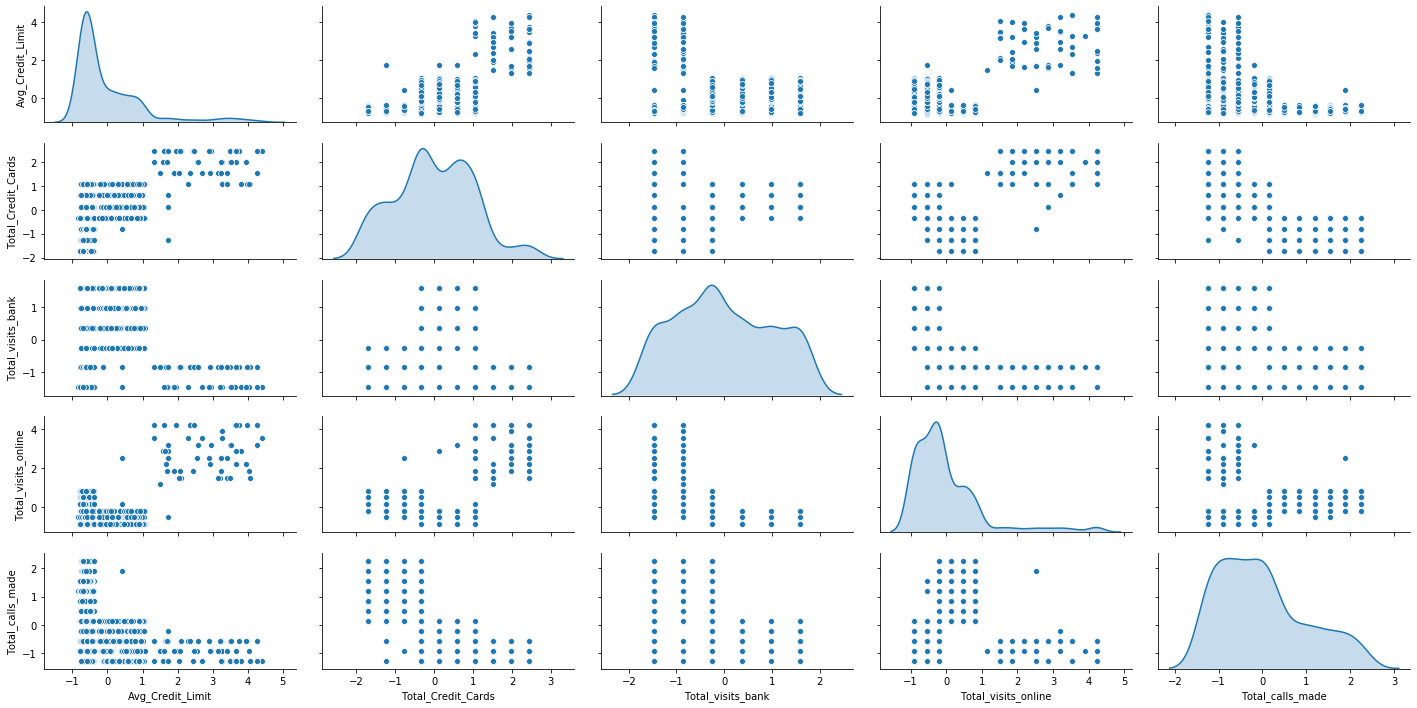

In [9]:
sns.pairplot(datak, height=2,aspect=2 , diag_kind='kde')

Text(0.5, 1, 'Correlation Matrix')

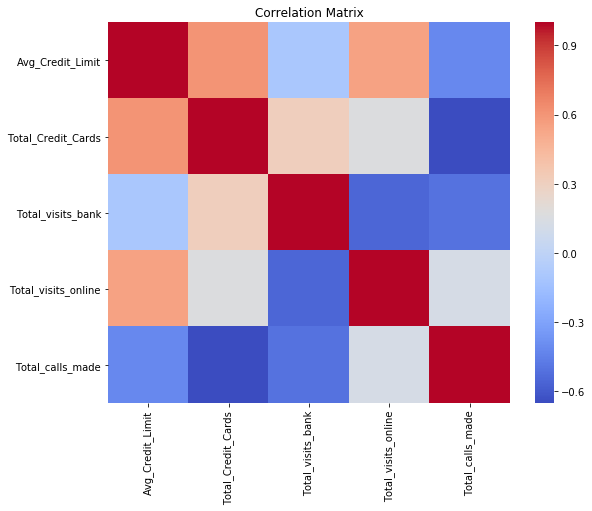

In [10]:
plt.figure(figsize=(9,7))
sns.heatmap(datak.corr(),cmap='coolwarm')
plt.title('Correlation Matrix')

#### Average credit limit has a string correlation with total number of credit cards and with the number of total visits online, this means that the clients with more credit limit tend to reduce the visits to the bank.

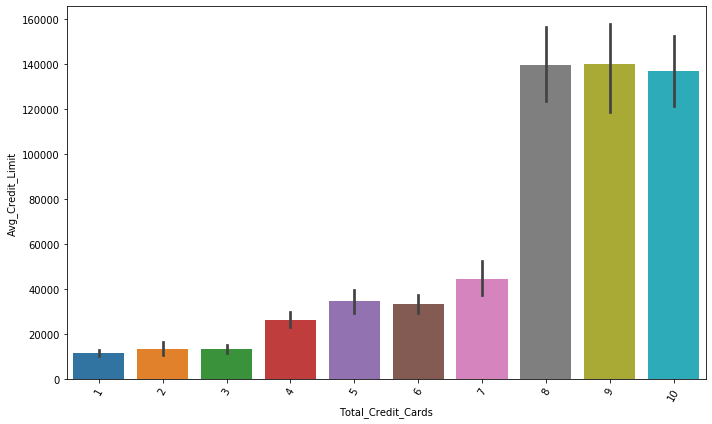

In [11]:
plt.figure(figsize=(10,6))
bar = sns.barplot(x="Total_Credit_Cards",y="Avg_Credit_Limit",data=df)
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.tight_layout()

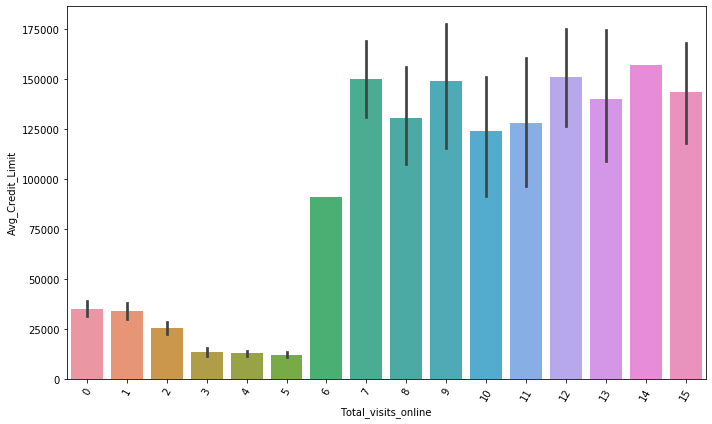

In [12]:
plt.figure(figsize=(10,6))
bar = sns.barplot(x="Total_visits_online",y="Avg_Credit_Limit",data=df)
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.tight_layout()

### There is a direct relation between the avg credit limit and the total credit cards per customer, that means the more credit cards the customer has his credit limit will be bigger, this is similar for the total visits online, the customers with more credit limit tend to visit more the webpage. Nevertheless with this information is still hard to identify the number of clusters that we can use but the selected features should be important for the grouping process. Probably we can create clusters for the clients that visit more the bank and also for the clients that use more the website

## Execute K-means clustering use  elbow  plot and  analyse  clusters  using  boxplot

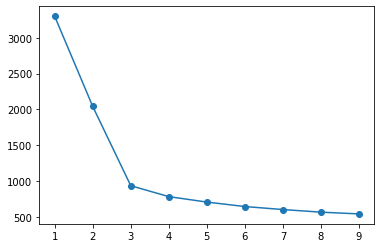

In [13]:
clusters=range(1,10)
distortions = []
for c in clusters:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(datak)
    distortions.append(kmeans.inertia_) #Using inertia

plt.figure()
plt.plot(clusters,distortions, marker='o')

### The elbow plot shows that the inertia decreases when the number of clusters increases. Inertia: Sum of squared distances of samples to their closest cluster center. Lets compare with the method used during the classes (Euclidian)

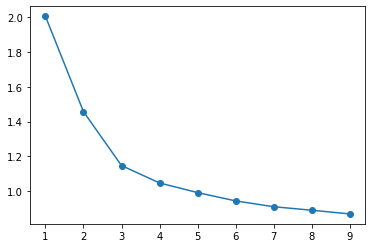

In [14]:
clusters=range(1,10)
distortions = []
for c in clusters:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(datak)
    prediction=kmeans.predict(datak)
    distortions.append(sum(np.min(cdist(datak, kmeans.cluster_centers_, 'euclidean'), axis=1)) / datak.shape[0])

plt.figure()
plt.plot(clusters,distortions, marker='o')

In [15]:
### Lets use another method to find the best number of clusters (Slhouette score)
scores = []
for c in range(2,40):
    kmeans = KMeans(n_clusters=c, random_state=0)
    score = silhouette_score(datak, kmeans.fit_predict(datak))
    scores.append({"clusters":c,"score":score})

In [16]:
max([s["score"] for s in scores]) ##Still 3 is the best option

0.5157182558881063

### Using euclidian distance the distortion appears between 2 and 3 clusters, so we can use those numbers of clusters. But i think using k = 3 will present more interesting results.

In [17]:
kmeans = KMeans(3)
kmeans.fit(datak)
datak["cluster"] = kmeans.predict(datak)
### Creating another column for the cluster group on each record

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f4e6cd0>,
      dtype=object)

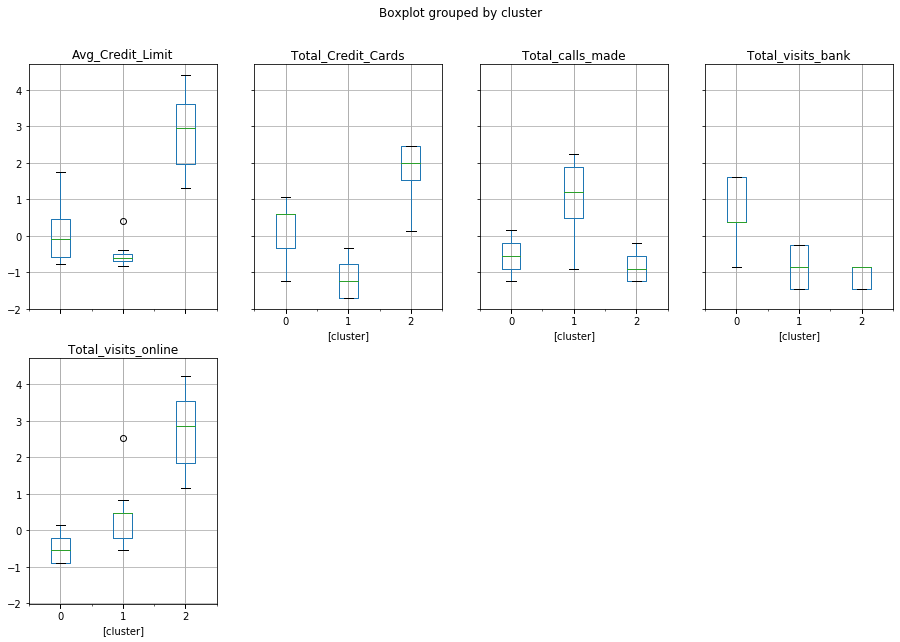

In [18]:
datak.boxplot(by='cluster', layout = (2,4),figsize=(15,10)) # BoxPlot

#### We can see in the boxplot graph that with 3 clusters we have a small number of outlayers (one) in only 2 columns, the rest can by grouped in one of the 3 clusters

## Execute hierarchicalclustering(with different linkages) with the help of dendrogram and cophenetic coeff. Analyse clusters formed using boxplot

In [19]:
dataz = data.apply(zscore)

In [20]:
methods = ["single","median","complete","average", "centroid", "ward"] ## Validate linkage with several methods

for method in methods:
    Z = linkage(dataz, metric='euclidean', method=method)
    c, coph_dists = cophenet(Z , pdist(dataz))
    print("Method: "+method+" = ", str(c))

Method: single =  0.7391220243806552
Method: median =  0.8893799537016724
Method: complete =  0.8599730607972423
Method: average =  0.8977080867389372
Method: centroid =  0.8939385846326323
Method: ward =  0.7415156284827493


<b> With this analysis we found that the best linkage methods for this model are <i>average</i> and <i>centroid</i> because they are closer to 1</b></p>
<h3>Average</h3>
This method assigns:
\begin{equation}
  d(u, v) = \sum_{ij} \frac{d(u[i],v[j])}{(|u|* |v|)}
\end{equation}
<br>
for all points <b>u</b> and <b>v</b> where <b>i</b> and <b>j</b> are the cardinalities of clusters  and , respectively. This is also called the UPGMA algorithm.
</p>
<hr>
<h3>Centroid</h3>
This method assigns:
\begin{equation}
    dist(s, t)= ||c_{s} - c_{t} ||_{2}
\end{equation}
<br>
where <b>c<sub>s</sub></b> and <b>c<sub>t</sub></b> are the centroids of clusters <b>s</b> and , <b>t</b> respectively. When two clusters <b>s</b> and <b>t</b> are combined into a new cluster <b>u</b>, the new centroid is computed over all the original objects in clusters <b>s</b> and <b>t</b>. The distance then becomes the <b>Euclidean</b> distance between the centroid of <b>u</b> and the centroid of a remaining cluster <b>v</b> in the forest. This is also known as the UPGMC algorithm.

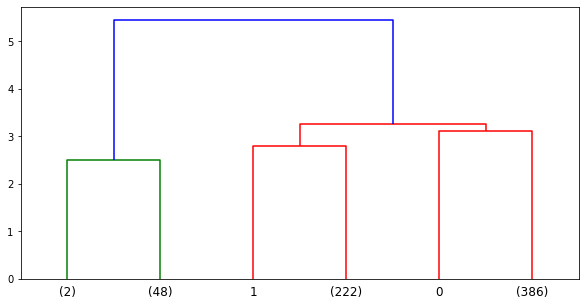

In [160]:
Z = linkage(dataz, metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(dataz))
plt.figure(figsize=(10, 5))
dendrogram(Z,show_leaf_counts=True, truncate_mode='lastp', p=6)
plt.show()

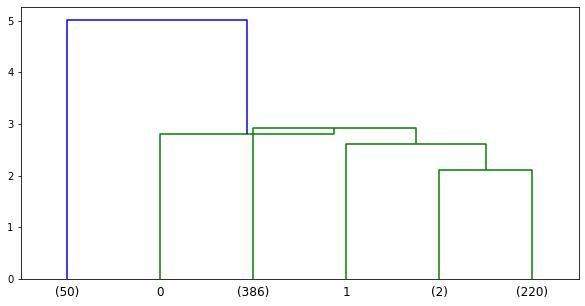

In [161]:
Z = linkage(dataz, metric='euclidean', method='centroid')
c, coph_dists = cophenet(Z , pdist(dataz))
plt.figure(figsize=(10, 5))
dendrogram(Z,show_leaf_counts=True, truncate_mode='lastp', p=6)
plt.show()

In [36]:
hclusters = fcluster(Z, 3, criterion='distance')
silhouette_score(dataz, hclusters)

0.5703183487340514

### Compare K-means clusters with Hierarchical clusters

In [158]:
kmeans = KMeans(n_clusters=3, random_state=0,max_iter=300)
y_kmeans = kmeans.fit_predict(datak)

Total_Credit_Cards


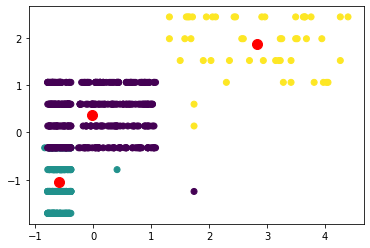

Total_visits_bank


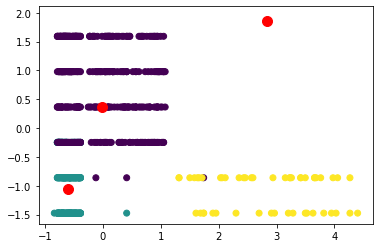

Total_visits_online


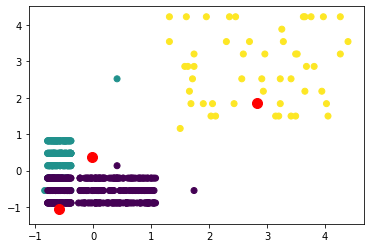

Total_calls_made


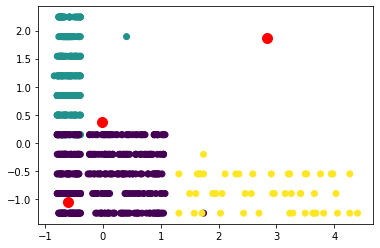

In [185]:
for c in datak.columns:
    if c != "Avg_Credit_Limit" and c != "cluster":
        print(c)
        plt.scatter(datak["Avg_Credit_Limit"], datak[c], c=y_kmeans)
        plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='red', label = 'Centroids')
        plt.show()


### With kmeans i found

In [179]:
hacluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='average')
y_labels = hacluster.fit_predict(dataz)

Total_Credit_Cards


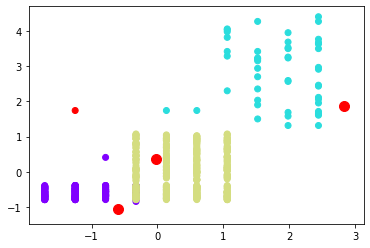

Total_visits_bank


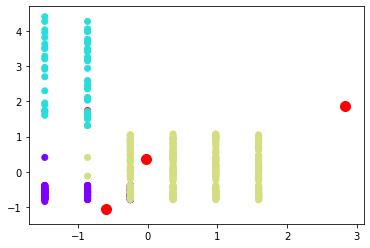

Total_visits_online


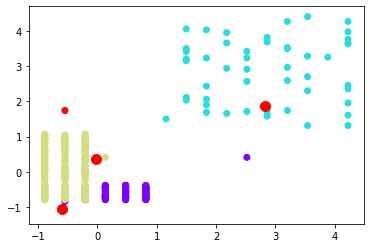

Total_calls_made


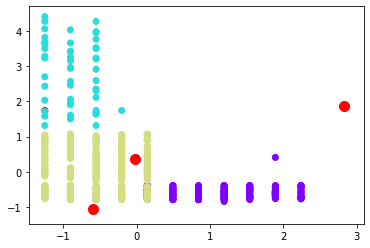

In [180]:
for c in dataz.columns:
    if c != "Avg_Credit_Limit":
        print(c)
        plt.scatter(dataz[c], dataz["Avg_Credit_Limit"], c=hacluster.labels_, cmap="rainbow")
        plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='red', label = 'Centroids')
        plt.show()

<h2>1. How many different segments of customers are there?</h2>
<b>I will say that we can find 3 types of segments. Customer by credit line, how often uses the online page and also by the number of credit cards</b>
<h2>2. How are these segments different from each other?</h2>
<b>We can say that the customers will typically have a higher credit line when they have more credit cards, and also the customers that visit more the web page will have more credit limit.</b>
<h2>3. What are your recommendations to the bank on how to better market to and service these customers?</h2>
<b>I will recommend having an strategy or a better offering of online products for those customers that have more than one credit line. Also by creating a chatbot we might reduce more the number of suppport calls and save costs around this service. The comercial team should also offer every new customer the online service and whenever they have another credit product we can create a campaing inside the online page or by sending emails to the customers in one of the main clusters</b>